In [34]:
using Distributions
using Random
using Plots

In [35]:
p = [0.1, 0.9]

2-element Array{Float64,1}:
 0.1
 0.9

In [36]:
m = Multinomial(32, p)

Multinomial{Float64}(n=32, p=[0.1, 0.9])

In [37]:
srand(9636)

UndefVarError: UndefVarError: srand not defined

In [38]:
rand(m, 3)

2×3 Array{Int64,2}:
  3   2   2
 29  30  30

In [39]:
function draw_dirichlet_multinomial(n::Integer, α::Vector{T1}, T::Real, K::Integer) where {T1 <: Real}
    cdf = DirichletMultinomial(n, T .* α ./ sum(α))
    return rand(cdf, K)
end

draw_dirichlet_multinomial (generic function with 1 method)

In [40]:
K = 3
p = [0.7, 0.2, 0.1]
T = 0.5
Xk = draw_dirichlet_multinomial(10, p, T, 10000)

3×10000 Array{Int64,2}:
 10  10  10  10  10  1  9   0  10  10  …  10   0  2  6   0  10  10  10  1  10
  0   0   0   0   0  0  1  10   0   0      0   0  8  4   0   0   0   0  0   0
  0   0   0   0   0  9  0   0   0   0      0  10  0  0  10   0   0   0  9   0

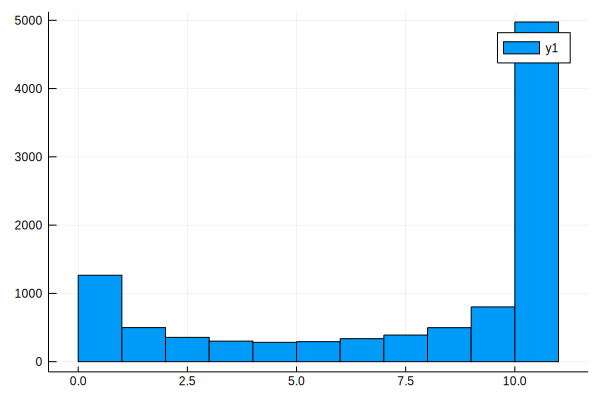

In [41]:
histogram(Xk[1,:])

In [42]:
function compute_KLD(share::Array{Float64,N}, p::Vector{Float64}) where {N}
    all(sum(share, dims=1) .≈ 1) || throw(ArgumentError("Shares have to sum to 1.")) 
    deviation = log.(share ./ p)
    # log(0) is fine because 0*log(0) = 0
    replace!(deviation, -Inf=>0)
    # convert to vector instead of 1xK array
    return sum(share .* deviation, dims=1)
end

compute_KLD (generic function with 1 method)

In [43]:
KLD = compute_KLD(Xk ./ sum(Xk, dims=1), p)


1×10000 Array{Float64,2}:
 0.356675  0.356675  0.356675  0.356675  …  0.356675  1.78291  0.356675

In [44]:
all(ones(3) .== 1)

true

In [103]:
include("./polya.jl")
using .Polya

In [104]:
cdf = Polya.estimate_dirichlet_multinomial(Xk, maxiter=1000)

DirichletMultinomial{Float64}(n=23, α=[459.26343359199615, 501.01465482763246])

In [100]:
typeof(compute_KLD)

typeof(compute_KLD)

In [48]:
Xk

3×10000 Array{Int64,2}:
 10  10  10  10  10  1  9   0  10  10  …  10   0  2  6   0  10  10  10  1  10
  0   0   0   0   0  0  1  10   0   0      0   0  8  4   0   0   0   0  0   0
  0   0   0   0   0  9  0   0   0   0      0  10  0  0  10   0   0   0  9   0

In [49]:
size(Xk, dims=1)

MethodError: MethodError: no method matching size(::Array{Int64,2}; dims=1)
Closest candidates are:
  size(::Array{T,2} where T) at array.jl:156 got unsupported keyword argument "dims"
  size(::Array{#s69,N} where #s69) where N at array.jl:157 got unsupported keyword argument "dims"
  size(::Array, !Matched::Integer) at array.jl:154 got unsupported keyword argument "dims"
  ...

In [50]:
A = ones(2, 3, 4)

2×3×4 Array{Float64,3}:
[:, :, 1] =
 1.0  1.0  1.0
 1.0  1.0  1.0

[:, :, 2] =
 1.0  1.0  1.0
 1.0  1.0  1.0

[:, :, 3] =
 1.0  1.0  1.0
 1.0  1.0  1.0

[:, :, 4] =
 1.0  1.0  1.0
 1.0  1.0  1.0

In [51]:
N = 3
sum(A, dims=2:N)

2×1×1 Array{Float64,3}:
[:, :, 1] =
 12.0
 12.0

In [52]:
length(size(A))

3

In [53]:
Xk = ones(Int, 2, 3, 4)
Xk[1] = 0

0

In [54]:
Polya.estimate_dirichlet_multinomial(Xk, maxiter=100000)

DirichletMultinomial{Float64}(n=23, α=[45748.392697121526, 49907.33748776891])

In [55]:
dims = size(Xk)

(2, 3, 4)

In [56]:
dims[2] = 1

MethodError: MethodError: no method matching setindex!(::Tuple{Int64,Int64,Int64}, ::Int64, ::Int64)

In [27]:
dims = ones(Int, 2)

2-element Array{Int64,1}:
 1
 1

In [28]:
dims[1] = 3

3

In [29]:
p

3-element Array{Float64,1}:
 0.7
 0.2
 0.1

In [30]:
reshape(p, dims...)

3×1 Array{Float64,2}:
 0.7
 0.2
 0.1

In [31]:
dims...

ErrorException: syntax: "..." expression outside call

simulate_KLD_ECDF (generic function with 1 method)

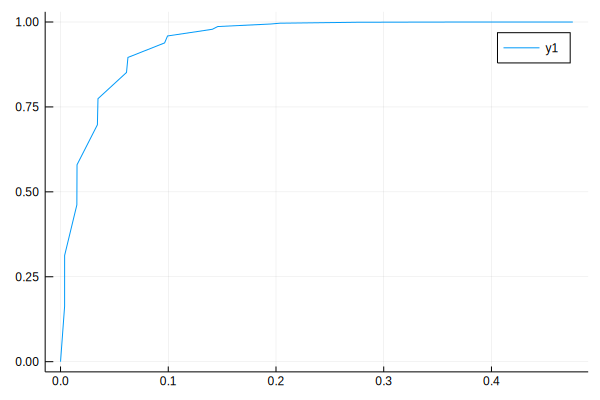

In [106]:
y = simulate_ECDF(cdf, compute_KLD)
plot(y.x, y.p)

evaluate_CDF (generic function with 1 method)

In [108]:
Polya.evaluate_CDF(y, 0.1)

0.9589004109958901

In [62]:
ci = CartesianIndex(2, 1)

CartesianIndex(2, 1)

In [63]:
ci.I

(2, 1)

In [93]:
include("ECDF.jl")
using .ECDF

In [94]:
ECDF.EmpiricalCDF

Main.ECDF.EmpiricalCDF